In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

**# LSTM MULTIVARIENT**

1.   This file imports the processed dataset with unique users per hour
2.   It creates a shape for the data according to need for LSTM which is external- user- 38 hours- in each hour -multiple data
3. then feeds to lstm






In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
import itertools
from itertools import combinations
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from collections import Counter
import nltk
from nltk.corpus import stopwords, words as nltk_words
from nltk.tokenize import word_tokenize
# from wordcloud import WordCloud
import matplotlib.cm as cm
import re
from nltk.stem import WordNetLemmatizer
import heapq
from tqdm import tqdm

# import pycountry
# from langdetect import detect
# from prettytable import PrettyTable



In [3]:

df = pd.read_csv('C:/Users/21301610/Downloads/code/combine/data_lstm_processed_unique_perhour_avg_values_combine_train.csv')
df.head()

,Unnamed: 0,Tweet Id,Tweet Posted Time,Tweet Content,Retweets Received,Likes Received,User Id,Username,Verified or Non-Verified,User Followers,User Following,Hour,Frequency,Tweet Type_encoded,Average Likes,Average Retweets
0,1,"""1570573128694370304""",2022-09-16 00:39:48,"""i will give $1,000 #bitcoin to my foll...",0,0.0,"""1000000628737765376""",henryfordking2,0,11,24,15.0,1,0,0.0,0.0
1,2,"""1570791442913841154""",2022-09-16 15:07:18,"""i will give $1,000 #bitcoin to my fol...",0,0.0,"""1000000628737765376""",henryfordking2,0,11,24,29.0,1,0,0.0,0.0
2,3,"""1570899128535904256""",2022-09-16 22:15:12,"""i will give $1,000 #bitcoin to my followers\...",0,0.0,"""1000000628737765376""",henryfordking2,0,11,24,37.0,1,0,0.0,0.0
3,4,"""1570408954945060864""",2022-09-15 13:47:26,"""given the sheer volume of misinformation &amp...",0,0.0,"""1000004500525060097""",deluxebyluk,0,126,685,4.0,2,0,0.0,0.0
4,5,"""1570769335924445195""",2022-09-16 13:39:27,"""the white house has no idea what #bitcoin is....",0,0.0,"""1000020055973945344""",MakoraNyaradzai,0,3103,2102,28.0,1,0,0.0,0.0


In [5]:
columns_to_keep = [#'Tweet Type_encoded',
                   'Retweets Received', 'Likes Received',
        'User  Id', 'Hour', 'Frequency', 'Verified or Non-Verified',  'User Followers',
       'User Following', 'Average Likes', 'Average Retweets']

df = df[columns_to_keep]
df.head()

,Retweets Received,Likes Received,User Id,Hour,Frequency,Verified or Non-Verified,User Followers,User Following,Average Likes,Average Retweets
0,0,0.0,"""1000000628737765376""",15.0,1,0,11,24,0.0,0.0
1,0,0.0,"""1000000628737765376""",29.0,1,0,11,24,0.0,0.0
2,0,0.0,"""1000000628737765376""",37.0,1,0,11,24,0.0,0.0
3,0,0.0,"""1000004500525060097""",4.0,2,0,126,685,0.0,0.0
4,0,0.0,"""1000020055973945344""",28.0,1,0,3103,2102,0.0,0.0


In [6]:
# prompt: printing total unique values of hour sorted

print(sorted(df['Hour'].unique()))


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0]


In [7]:
# # # prompt: take a random shuffled subset of the df of like 10%

# df = df.sample(frac=0.01, random_state=42)
# df.head()


In [8]:
df.shape

(138325, 10)

In [9]:
# prompt: I want to process this for LSTM. so creating a vector, inside that for each user there will be a separate vector- inside which for each hour there will be 38 vectors for 38 hours of data. inside each hour vector there will be the data of Tweet Type_encoded	Retweets Received	Likes Received  Frequency	Verified or Non-Verified	User Followers	User Following. shape like [[[],[]..],[[],[]...]..]

def create_user_vector(df):
  user_vector = []
  for user_id in df['User  Id'].unique():
    user_df = df[df['User  Id'] == user_id]
    hour_vector = []
    for hour in range(39):
      hour_df = user_df[user_df['Hour'] == hour]
      if not hour_df.empty:
        features = hour_df[['Retweets Received', 'Likes Received', 'Verified or Non-Verified', 'User Followers', 'User Following','Average Likes', 'Average Retweets','Frequency']].values.tolist()[0]
        hour_vector.append(features)
      else:
        hour_vector.append([0] * 8)  # Pad with zeros if no data for that hour
    user_vector.append(hour_vector)
  return user_vector

lstm_data = create_user_vector(df)


In [10]:
# prompt: printing some of lstm_data in a way to help me visualize it's structure properly.  also printing its dimensions.

# Print the shape of the lstm_data
print("Shape of lstm_data:", np.array(lstm_data).shape)

# Print the first user's data for the first 5 hours
print("\nFirst user's data for the first 5 hours:")
for i in range(39):
  print(f"Hour {i}: {lstm_data[0][i]}")

# Print the first 5 users' data for the first hour
print("\nFirst 5 users' data for the first hour:")
for i in range(5):
  print(f"User {i}: {lstm_data[i][0]}")


Shape of lstm_data: (86353, 39, 8)

First user's data for the first 5 hours:
Hour 0: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 1: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 2: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 3: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 4: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 5: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 6: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 7: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 8: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 9: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 10: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 11: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 12: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 13: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 14: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 15: [0.0, 0.0, 0.0, 11.0, 24.0, 0.0, 0.0, 1.0]
Hour 16: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 17: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 18: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 19: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 20: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 21: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 22: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 23: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 24: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 25: [0, 0, 0, 0, 0, 0, 0, 0]
Hour 26: [0, 0, 0, 0, 0, 0, 0, 

In [11]:
# prompt: total number of unique user  ids in df

len(df['User  Id'].unique())h


86353

In [12]:
# # prompt:  imputing for the data in lstm_data to make sure the hours data which has no data because there is no user  id, those are not filled wth zeros only.

# def impute_missing_data(lstm_data):
#   for user_data in lstm_data:
#     for hour in range(39):
#       if user_data[hour] == [0] * 8:
#         # Impute with the average of the previous and next hour's data
#         prev_hour = (hour - 1) % 39
#         next_hour = (hour + 1) % 39
#         if user_data[prev_hour] != [0] * 8 or user_data[next_hour] != [0] * 8:
#           imputed_data = [(a + b) / 2 for a, b in zip(user_data[prev_hour], user_data[next_hour])]
#           user_data[hour] = imputed_data
#   return lstm_data

# lstm_data = impute_missing_data(lstm_data)


In [13]:
# # prompt: similar to last imputing moving forward. do a backward check to impute the earlier values.

# def impute_missing_data_backward(lstm_data):
#   for user_data in lstm_data:
#     for hour in range(38, -1, -1):  # Iterate backwards
#       if user_data[hour] == [0] * 8:
#         # Impute with the average of the previous and next hour's data
#         prev_hour = (hour - 1) % 39
#         next_hour = (hour + 1) % 39
#         if user_data[prev_hour] != [0] * 8 or user_data[next_hour] != [0] * 8:
#           imputed_data = [(a + b) / 2 for a, b in zip(user_data[prev_hour], user_data[next_hour])]
#           user_data[hour] = imputed_data
#   return lstm_data

# lstm_data = impute_missing_data_backward(lstm_data)


In [27]:
# import pickle

# # Export lstm_data to a file using pickle
# with open('lstm_data.pkl', 'wb') as file:
#     pickle.dump(lstm_data, file)

# print("lstm_data has been successfully exported.")


lstm_data has been successfully exported.


In [ ]:
# import pickle

# # Import lstm_data from the file
# with open('lstm_data.pkl', 'rb') as file:
#     lstm_data_loaded = pickle.load(file)

# print("lstm_data has been successfully imported.")


In [15]:
# import random

# # Shuffle the user data
# random.shuffle(lstm_data)

In [16]:
# # prompt: print some of lstm_data in a way to help me visualize it's structure properly.  also print its dimensions.

# # Print the shape of the lstm_data
# print("Shape of lstm_data:", np.array(lstm_data).shape)

# # Print the first user's data for the first 5 hours
# print("\nFirst user's data for the first 5 hours:")
# for i in range(39):
#   print(f"Hour {i}: {lstm_data[0][i]}")

# # Print the first 5 users' data for the first hour
# print("\nFirst 5 users' data for the first hour:")
# for i in range(5):
#   print(f"User {i}: {lstm_data[i][0]}")


In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming lstm_data is your original data

# Convert lstm_data to a numpy array
lstm_data_array = np.array(lstm_data)
print("Original lstm_data_array shape:", lstm_data_array.shape)

# Separate the last column from the rest of the data
X = lstm_data_array[:, :, :-1]  # All columns except the last one
last_column = lstm_data_array[:, :, -1]  # Last column only
print("Shape of X (all columns except last):", X.shape)
print("Shape of last_column (last column only):", last_column.shape)

# Reshape for scaling
X_reshaped = X.reshape(-1, X.shape[-1])
last_column_reshaped = last_column.reshape(-1, 1)
print("Shape of X_reshaped for scaling:", X_reshaped.shape)
print("Shape of last_column_reshaped for scaling:", last_column_reshaped.shape)

# Create StandardScaler objects for different scaling
scaler_X = StandardScaler()
scaler_last = StandardScaler()

# Fit and transform the data
X_scaled = scaler_X.fit_transform(X_reshaped)
last_column_scaled = scaler_last.fit_transform(last_column_reshaped)
print("Shape of X_scaled after transformation:", X_scaled.shape)
print("Shape of last_column_scaled after transformation:", last_column_scaled.shape)

# Reshape back to the original shape
X_scaled = X_scaled.reshape(lstm_data_array.shape[0], lstm_data_array.shape[1], -1)
last_column_scaled = last_column_scaled.reshape(lstm_data_array.shape[0], lstm_data_array.shape[1], 1)

print("Shape of X_scaled after reshaping:", X_scaled.shape)
print("Shape of last_column_scaled after reshaping:", last_column_scaled.shape)

# Concatenate the scaled data
lstm_data_normalized = np.concatenate((X_scaled, last_column_scaled), axis=-1)
print("Shape of lstm_data_normalized after concatenation:", lstm_data_normalized.shape)


Original lstm_data_array shape: (86353, 39, 8)
Shape of X (all columns except last): (86353, 39, 7)
Shape of last_column (last column only): (86353, 39)
Shape of X_reshaped for scaling: (3367767, 7)
Shape of last_column_reshaped for scaling: (3367767, 1)
Shape of X_scaled after transformation: (3367767, 7)
Shape of last_column_scaled after transformation: (3367767, 1)
Shape of X_scaled after reshaping: (86353, 39, 7)
Shape of last_column_scaled after reshaping: (86353, 39, 1)
Shape of lstm_data_normalized after concatenation: (86353, 39, 8)


In [18]:
# # prompt: now normalize the lstm_data by using standard scaler

# from sklearn.preprocessing import StandardScaler

# # Reshape the data for scaling
# lstm_data_reshaped = np.array(lstm_data).reshape(-1, 8)

# # Create a StandardScaler object
# scaler = StandardScaler()

# # Fit and transform the data
# lstm_data_scaled = scaler.fit_transform(lstm_data_reshaped)

# # Reshape the data back to its original shape
# lstm_data_normalized = lstm_data_scaled.reshape(np.array(lstm_data).shape)

# # Print the shape of the normalized lstm_data
# print("Shape of lstm_data_normalized:", lstm_data_normalized.shape)


In [19]:
# # prompt: print some of lstm_data in a way to help me visualize it's structure properly.  also print its dimensions.

# # Print the shape of the lstm_data
# print("Shape of lstm_data:", np.array(lstm_data_normalized).shape)

# # Print the first user's data for the first 5 hours
# print("\nFirst user's data for the first 5 hours:")
# for i in range(39):
#   print(f"Hour {i}: {lstm_data_normalized[0][i]}")

# # Print the first 5 users' data for the first hour
# print("\nFirst 5 users' data for the first hour:")
# for i in range(5):
#   print(f"User {i}: {lstm_data_normalized[i][0]}")


In [20]:
# Calculate the split indices (90% for training and 10% for validation)
train_size = int(0.9 * len(lstm_data_normalized))
val_size = len(lstm_data_normalized) - train_size

# Split the data
train_data = lstm_data_normalized[:train_size]
val_data = lstm_data_normalized[train_size:]

# Print the shapes of the split data
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)


Train data shape: (77717, 39, 8)
Validation data shape: (8636, 39, 8)


In [21]:
# prompt: so the shape is (1059, 39, 7) for train_data. from this, create train_x so that the shape is (1059,37,7). hence for each instance take only the first 37 in x and create train_y where for each user the last 2 will be there with shape (1059,2,7)

# Create train_x and train_y
train_x = train_data[:, :38, :]
train_y = train_data[:, 38:, :]

# test_x = test_data[:, :38, :]
# test_y = test_data[:, 38:, :]

val_x = val_data[:, :38, :]
val_y = val_data[:, 38:, :]

# Print the shapes of train_x and train_y
print("Train x shape:", train_x.shape)
print("Train y shape:", train_y.shape)
# print("Test x shape:", test_x.shape)
# print("Test y shape:", test_y.shape)
print("Validation x shape:", val_x.shape)
print("Validation y shape:", val_y.shape)


Train x shape: (77717, 38, 8)
Train y shape: (77717, 1, 8)
Validation x shape: (8636, 38, 8)
Validation y shape: (8636, 1, 8)


In [22]:
print(train_y[0])

[[-0.00496104 -0.00809696 -0.01313574 -0.01209958 -0.05196782 -0.007176
  -0.00438356 -0.10481759]]


In [23]:
# prompt: in trainy test y and valy, remove values of the last dimension and make it 1 by keeping only the last entry. So the shape of train y becomes (1059,1,1) where out of the 6 values in the last dimension only the last value will be present.

train_y = train_y[:, :, -1].reshape(train_y.shape[0], 1, 1)
# test_y = test_y[:, :, -1].reshape(test_y.shape[0], 1, 1)
val_y = val_y[:, :, -1].reshape(val_y.shape[0], 1, 1)

# Print the shapes of train_x and train_y
print("Train x shape:", train_x.shape)
print("Train y shape:", train_y.shape)
# print("Test x shape:", test_x.shape)
# print("Test y shape:", test_y.shape)
print("Validation x shape:", val_x.shape)
print("Validation y shape:", val_y.shape)


Train x shape: (77717, 38, 8)
Train y shape: (77717, 1, 1)
Validation x shape: (8636, 38, 8)
Validation y shape: (8636, 1, 1)


In [24]:
# prompt: create an LSTM model so that it can predict all 7 features for the last hour 1 hour that is in train y.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers

# Define the model
model = Sequential()
model.add(LSTM(38, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))  # Dropout after the first LSTM layer
model.add(LSTM(38, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))  # Dropout after the second LSTM layer
model.add(Dense(1))  # Output layer with 1 units for the 1 features

# Compile the model (you'll need to choose an optimizer and loss function)
model.compile(loss='mse', optimizer='adam')

# Print the model summary
model.summary()


C:\Users\21301610\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 38, 38)              │           7,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 38)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 38)                  │          11,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 38)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              39 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,887 (73.78 KB)

 Trainable params: 18,887 (73.78 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# history = model.fit(train_x, train_y, epochs=5, batch_size=32, validation_data=(val_x, val_y))

In [28]:
# prompt: now implement early stopping

from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Fit the model with early stopping
history = model.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(val_x, val_y), callbacks=[early_stopping])


Epoch 1/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.3555 - val_loss: 0.5126
Epoch 2/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.2671 - val_loss: 0.5092
Epoch 3/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.3355 - val_loss: 0.5043
Epoch 4/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.3138 - val_loss: 0.5140
Epoch 5/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.2228 - val_loss: 0.5156
Epoch 6/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.3327 - val_loss: 0.4988
Epoch 7/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.4308 - val_loss: 0.4894
Epoch 8/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.3359 - val_loss: 0.4932
Epoch 9/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.2099 - val_loss: 0.4813
Epoch 10/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.3571 - val_loss: 0.4828
Epoch 11/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.4410 - val_loss: 0.4741

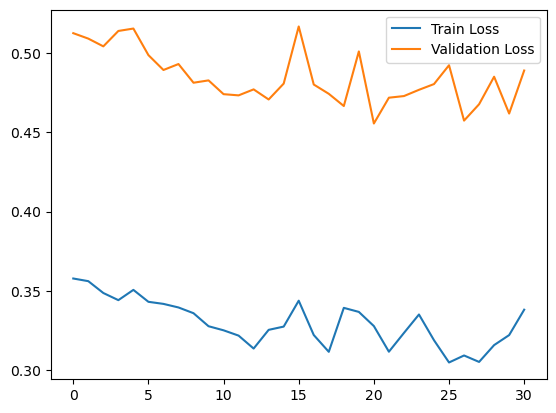

In [29]:


# Plot train and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [30]:
# # Save the trained model to the same folder as your dataset
# model.save('C:/Users/21301610/Downloads/combine/lstm_model_multivarient_base.h5')
# model.save('C:/Users/21301610/Downloads/combine/lstm_model_multivarient_base.keras')

In [31]:
# import pickle

# # Load lstm_data from the file
# with open('lstm_data.pkl', 'rb') as file:
#     lstm_data = pickle.load(file)

# print("lstm_data has been loaded successfully.")
